#  **California Covid 19 Cases Time Series Weekly Prediction**
MA 641 Group 3 Project - Part A
Authors: Nick Gokul and Samruth
7/15/22


---

## CHHS Open Data
Statewide COVID-19 Cases Deaths Tests

data:
https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a



---
## Parts of the Project



In [1]:
# install packages
%pip install pmdarima
%pip install statsmodels --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import pylab 
import scipy.stats as stats
import pmdarima as pm
import os

# Specific packaages
from IPython.display import display, HTML
from google.colab import data_table, files
from matplotlib import dates as mdates

# Modeling
import statsmodels.api as sm
from statsmodels import tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit



In [3]:
os.getcwd()

'/content'

In [4]:
from google.colab import drive
drive.mount("/content/drive")
print(os.getcwd())
path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [5]:
# Load other files
%%capture
%run eacf.py

In [6]:
# Settings
plt.style.use('fivethirtyeight')
data_table.enable_dataframe_formatter()

In [7]:
# Variables
season = 52

### Functions

In [8]:
# Functions
def get_california_covid_cases(cases_only = True):
    chhs_url = "https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv"
    chhs_data = pd.read_csv(chhs_url)
    df_chhs = chhs_data
    df_california = df_chhs.loc[df_chhs.loc[:, 'area_type']== 'State' , :]
    # reset index
    df_california = df_california.reset_index()
    # make datetime
    df_california.loc[:, "date"] = df_california.loc[:, "date"].astype("datetime64")
    # remove last 2 rows - not reported
    df_california.drop(df_california.tail(2).index, inplace = True)
    
    if cases_only:
        df_cal_daily = df_california.loc[:, ['date', 'cases']].set_index(['date'])
    else:
        df_cal_daily = df_california.loc[:, :].set_index(['date'])
    
    return df_cal_daily


def dickey_fuller_test_results(p_value):
  if p_value < 0.05:
    print(f'The null hypothesis can be rejected. The time-series is stationary. ({round(p_value, 4)} < 0.05)')
  else:
    print(f'The null hypothesis cannot be rejected. The time-series is not stationary. ({round(p_value, 4)} > 0.05)')

  return None


def find_prediction_acc(y_pred, y_true, print_result=True):

  y_pred = y_pred.reshape(-1,1)
  y_true = y_true.reshape(-1,1)
  mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) # Mean absolute percentage error
  mae = np.mean(np.abs(y_pred- y_true))   # mean absolute error
  mpe = np.mean((y_pred - y_true) / y_true) # Mean percentage error
  rmse = np.mean((y_pred - y_true) **2)**(1/2)  # RMSE
  corr = np.corrcoef(y_pred, y_true)[0, 1]  # Correlation Coefficient

  mins = np.amin(np.hstack([y_pred.reshape(-1,1), y_true.reshape(-1,1)]), axis=1)
  maxs = np.amax(np.hstack([y_pred.reshape(-1,1), y_true.reshape(-1,1)]), axis=1)
  minmax = 1 - np.mean(mins.reshape(-1,1) / maxs.reshape(-1,1)) # minmax
  
  accuracy_results = {
      'mape' : round(mape, 3), 'mae' :  round(mae, 3), 'mpe' : round(mpe, 3), 
      'rmse' : round(rmse, 3), 'corr' : round(corr, 3), 'minmax' :  round(minmax, 3)}

  if print_result:
    pprint.pprint(accuracy_results)
  return accuracy_results


def shapiro_wilk_test(data, alpha= 0.05):
  test_results = stats.shapiro(data_train)
  print('Shapiro-Wilk Test:')
  print(test_results)
  if test_results.pvalue < alpha:
    print(f"p-value: {round(test_results.pvalue, 4)}. The null-hypothesis can be rejected. The data is not normally distributed.")
  else:
    print(f"p-value: {round(test_results.pvalue, 4)}. The null-hypothesis cannot be rejected. The data is normally distributed.")

  return test_results




In [9]:
# Plot Function
def covid_plot_ts_acf_pacf(data, tranformation_type, x_label_name, y_label_name, data_type_name= 'Daily', color_plot = '#30a2da'):
  '''
  Plot Time Series ACF and PCF
  '''
  # figure size
  ts_fig_size = (10, 4)
  acf_pacf_fig_size = (12,4)

  #Plot Time Series
  plt.figure(figsize= ts_fig_size, dpi=80)
  plt.plot( data, marker='o', markersize=2, linewidth=2, color=color_plot)
  plt.title(f'California {data_type_name} Covid-19 Cases {tranformation_type}')
  plt.xticks(rotation=45, ha='right')
  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)
  plt.show()


  # acf pacf plts
  fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
  # acf
  sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=35, ax=ax[0], color=color_plot)
  # pacf
  sm.graphics.tsa.plot_pacf(data, lags=35, ax=ax[1], color=color_plot) 
  plt.show()
  
  return None

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AutoReg

def eacf(z, ar_max=7, ma_max=13, display=True):
    """
    Translation of the eacf function from R into Python.
   
    Original documentation:
    
    #
    #  PROGRAMMED BY K.S. CHAN, DEPARTMENT OF STATISTICS AND ACTUARIAL SCIENCE,
    #  UNIVERSITY OF IOWA.
    #
    #  DATE: 4/2001
    #  Compute the extended sample acf (ESACF) for the time series stored in z.
    #  The matrix of ESACF with the AR order up to ar.max and the MA order
    #  up to ma.max is stored in the matrix EACFM.
    #  The default values for NAR and NMA are 7 and 13 respectively.
    #  Side effect of the eacf function:
    #  The function prints a coded ESACF table with
    #  significant values denoted by * and nosignificant values by 0, significance
    #  level being 5%.
    #
    #  Output:
    #   eacf=matrix of esacf
    #   symbol=matrix of coded esacf
    #
    """

    def lag1(z, lag=1):
        return pd.Series(z).shift(lag)
    
    def reupm(m, nrow, ncol):
        k = ncol - 1
        m2 = np.empty((m.shape[0], k))
        for i in range(k):
            i1 = i + 1
            work = lag1(m1[:, i])
            work[0] = -1
            temp = m1[:, i1] - work * m1[i1, i1]/m1[i, i]
            temp[i1] = 0
            m2[:, i] = temp
        return m2
    
    def ceascf(m, cov1, nar, ncol, count, ncov, z, zm):
        result = np.zeros(nar+1)
        result[0] = cov1[ncov + count - 1]
        for i in range(1, nar+1):
            A = np.empty((len(z) - i, i+1))
            A[:, 0] = z[i:]
            A[:, 1:] = zm[i:, :i]
            b = np.r_[1, -m[:i, i-1]]
            temp = A @ b
            result[i] = acf(temp, nlags=count, fft=False)[count]
        return result
    
    ar_max = ar_max + 1
    ma_max = ma_max + 1
    nar = ar_max - 1
    nma = ma_max
    ncov = nar + nma + 2
    nrow = nar + nma + 1
    ncol = nrow - 1
    z = np.array(z) - np.mean(z)
    zm = np.empty((len(z), nar))
    for i in range(nar):
        zm[:, i] = lag1(z, lag=i+1)
    cov1 = acf(z, nlags=ncov, fft=False)
    cov1 = np.r_[np.flip(cov1[1:]), cov1]
    ncov = ncov + 1
    m1 = np.zeros((nrow, ncol))
    for i in range(ncol):
        m1[:i+1, i] = AutoReg(z, lags=i+1, trend='c').fit().params[1:]
        
    eacfm = np.empty((ar_max, nma))
    for i in range(nma):
        m2 = reupm(m = m1, nrow = nrow, ncol = ncol)
        ncol = ncol - 1
        eacfm[:, i] = ceascf(m2, cov1, nar, ncol, i+1, ncov, z, zm)
        m1 = m2
    
    work = np.arange(1, nar+2)
    work = len(z) - work + 1
    symbol = np.empty(eacfm.shape, dtype=object)
    for i in range(nma):
        work = work - 1
        symbol[:, i] = np.where(np.abs(eacfm[:, i]) > 2/np.sqrt(work), 'x', 'o')
    
    symbol = pd.DataFrame(symbol)
    if display:
        print('AR / MA')
        print(symbol)
    
    return {
        'eacf': eacfm,
        'ar.max': ar_max,
        'ma.max': ma_max,
        'symbol': symbol
    }s

# Load Data


In [10]:
data_daily_covid_cases = get_california_covid_cases()
display(data_daily_covid_cases.head(10))
display(data_daily_covid_cases.describe())

,cases
date,
2020-02-01,24.0
2020-02-02,9.0
2020-02-03,7.0
2020-02-04,1.0
2020-02-05,3.0
2020-02-06,7.0
2020-02-07,32.0
2020-02-08,7.0
2020-02-09,6.0


,cases
count,922.000000
mean,10959.048807
std,18748.239341
min,1.000000
25%,2291.250000
50%,5195.500000
75%,11306.000000
max,156161.000000


### Weekly Data
Data is grouped by week. This will remove trends in any daily reporting. 

In [11]:
# Weekly Cases
data_weekly = data_daily_covid_cases.copy().reset_index()
data_weekly['date'] = data_weekly['date'] - pd.to_timedelta(7, unit='d')
data_weekly = data_weekly.groupby([ pd.Grouper(key='date', freq='W-MON')])['cases'].sum().reset_index().sort_values('date')
data_weekly = data_weekly.set_index(['date'])
print('Weekly Cases:')
display(data_weekly.head(5))
display(data_weekly.tail(5))
display(data_weekly.describe())

Weekly Cases:


,cases
date,
2020-01-27,40.0
2020-02-03,62.0
2020-02-10,53.0
2020-02-17,138.0
2020-02-24,354.0


,cases
date,
2022-07-11,128475.0
2022-07-18,116525.0
2022-07-25,95374.0
2022-08-01,73087.0
2022-08-08,8393.0


,cases
count,133.000000
mean,75971.751880
std,121987.216183
min,40.000000
25%,15722.000000
50%,37250.000000
75%,84046.000000
max,861069.000000


# Plots

### Daily, Weekly, Monthly Time Series Plot
Examine time series plots

In [12]:
# Daily Cases
data_daily = data_daily_covid_cases.copy().reset_index().set_index(['date'])


# Weekly Cases
data_weekly = data_daily.copy().reset_index()
data_weekly['date'] = data_weekly['date'] - pd.to_timedelta(7, unit='d')
data_weekly = data_weekly.groupby([ pd.Grouper(key='date', freq='W-MON')])['cases'].sum().reset_index().sort_values('date').set_index(['date'])


# Monthly Cases
data_monthly = data_daily.copy()
data_monthly['year'] = data_monthly.index.year; data_monthly['month'] = data_monthly.index.month
data_monthly = data_monthly.groupby(['year', 'month']).sum().reset_index()

# covert month and date to first month of every year
data_monthly1 =  data_monthly.set_index(pd.to_datetime(data_monthly[['year','month']].assign(day=1))).loc[:,'cases']
del data_monthly

View size of dataset broken out by day week and month

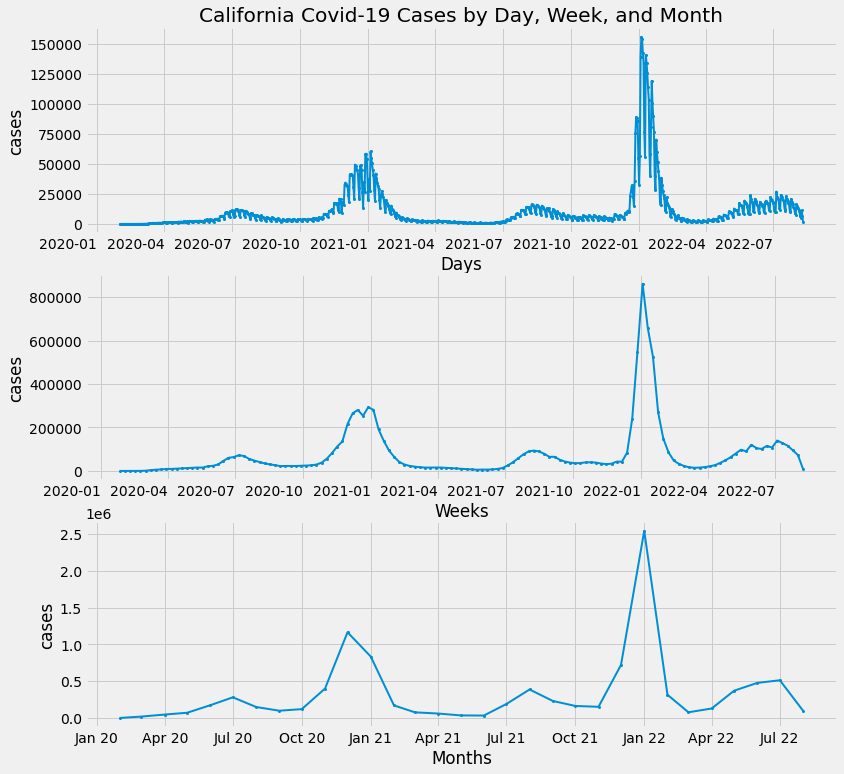

Daily Data Shape: (922, 1)
Weekly Data Shape: (133, 1)
Monthly Data Shape: (31,)


In [13]:
# Plot Daily, Monthly, and Weekly
from matplotlib import dates as mdates

plt.figure(figsize=(12, 12))


# Daily Plot
plt.subplot(3,1, 1)
#plt.figure(figsize= ts_fig_size, dpi=80)
plt.plot(data_daily, marker='o', linewidth= 2, markersize=2)
plt.xticks(rotation=0, ha='right')
plt.title('California Covid-19 Cases by Day, Week, and Month')
plt.xlabel('Days')
plt.ylabel('cases')
#plt.show()

# Weekly Plot
plt.subplot(3,1, 2)
plt.plot(data_weekly, marker='o', linewidth= 2, markersize=2)
plt.xticks(rotation=0, ha='right')
#plt.title('California Covid-19 Cases by Week')
plt.xlabel('Weeks')
plt.ylabel('cases')
#plt.show()

# Monthly Plot
s = plt.subplot(3,1, 3)
s.plot(data_monthly1, marker='o', linewidth= 2, markersize=2)
s.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xlabel('Months')
plt.ylabel('cases')

plt.show()


print(f'Daily Data Shape: {data_daily.shape}')
print(f'Weekly Data Shape: {data_weekly.shape}')
print(f'Monthly Data Shape: {data_monthly1.shape}')

Weekly data was chosen because there are enough records to build a model.

### Season Decomposition

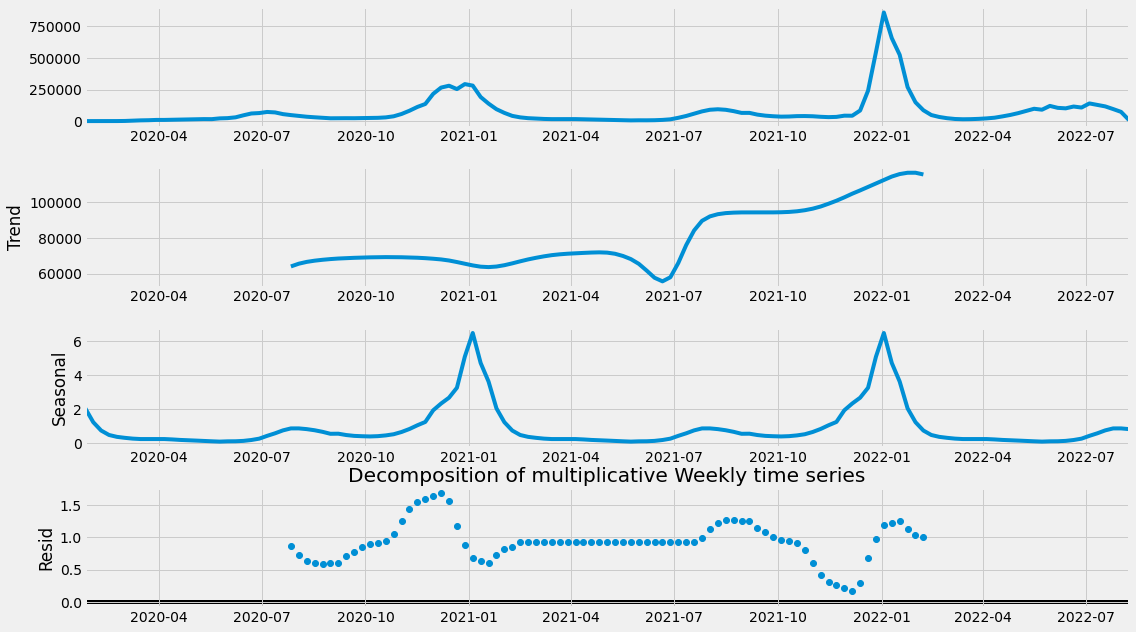

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

model_type = 'multiplicative' # additive, multiplicative
data_season_breakdown = data_weekly

result = seasonal_decompose(data_season_breakdown, model=model_type)
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.title(f'Decomposition of {model_type} Weekly time series')
plt.show()

There seems to be some seasonality in the dataset. It is worth noting the two peaks in January of 2021 and January 2022.

## Time Sereis Plots (TS, ACF, pACF)

In [15]:
# Variables
data_type_name = 'Weekly'

# stationary p-value data frame
stationary_pvalue_map = {'Transformation' : [], 'Pvalue' : []}
x_label_name = 'Time (Weeks)'

### No Tranformation - Weekly

In [16]:
data = data_weekly.copy()

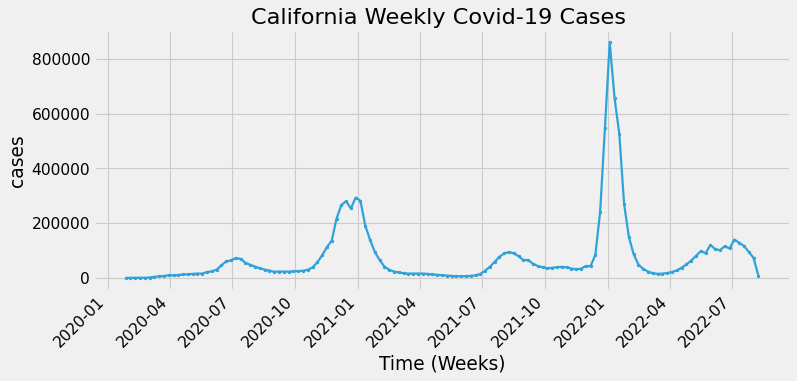

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


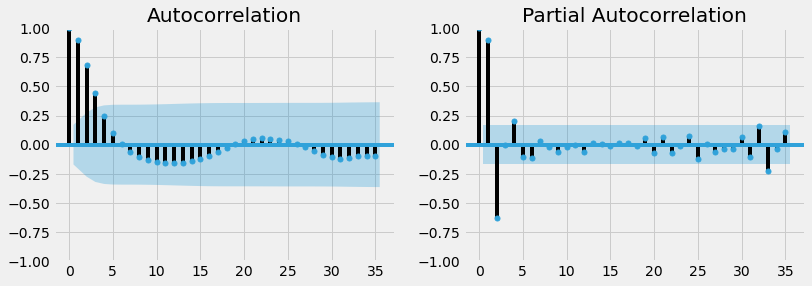


Dickey-Fuller test:
(-5.164906410663707, 1.0364542177839941e-05, 1, 131, {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}, 2893.6044560877062)
p-value: 1.0364542177839941e-05
The null hypothesis can be rejected. The time-series is stationary. (0.0 < 0.05)


In [17]:
# No Tranformation
# plot information
data_plot = data.loc[:, 'cases']
tranformation_type = ''
y_label_name = 'cases'
color_plot = '#30a2da' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
adf_pvalue = result[1]
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {adf_pvalue}')
dickey_fuller_test_results(adf_pvalue)

stationary_pvalue_map['Transformation'].append(f'{data_type_name} {tranformation_type}')
stationary_pvalue_map['Pvalue'].append(result[1])

#### Stationary
The data seems to be stationary without any transformation. The pvalue from the Dickey-Fuller test is 0.0. The ACF shows an exponential decay. The pACF shows a strong correlation at lags 1 and 2 and a moderate correlation at lags 3 and 4.

In [18]:
_ = eacf(data_plot, ma_max=10, ar_max=10)

AR / MA
   0  1  2  3  4  5  6  7  8  9  10
0   x  x  x  x  o  o  o  o  o  o  o
1   x  x  x  o  o  o  o  o  o  o  o
2   o  x  o  o  o  o  o  o  o  o  o
3   o  x  o  o  o  o  o  o  o  o  o
4   x  x  x  x  o  o  o  o  o  o  o
5   x  x  x  x  o  o  o  o  o  o  o
6   x  o  x  o  o  o  o  o  o  o  o
7   x  o  x  x  o  o  o  o  o  o  o
8   x  x  o  x  o  o  o  o  o  o  o
9   x  o  o  o  o  o  o  o  o  o  o
10  x  o  x  o  x  o  o  o  o  o  o


The extended autocorrelation plot does not show a good combination of parameters for an ARIMA model. The ACF and pACF plot that the model is purely autoregressive

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


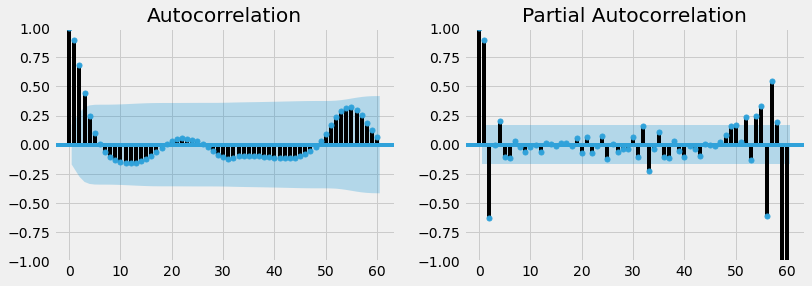

In [19]:
# No Tranformation
# acf pacf plts
fig, ax = plt.subplots(1,2,figsize= (12,4))
# acf
sm.graphics.tsa.plot_acf(data_weekly.values.squeeze(), lags=60, ax=ax[0], color=color_plot)
#sm.graphics.tsa.plot_acf(data.values.squeeze(), ax=ax[0], color=color_plot)
# pacf
sm.graphics.tsa.plot_pacf(data_weekly, lags=60, ax=ax[1], color=color_plot)
plt.show()

There apeears to be some noise one season out in the pACF.  The data does also to apear to grow in the ACF one season out, but not to a level of significace.

### Seasonal Tranformation - Weekly

In [20]:
data_seasondiff = data.copy().diff(season).iloc[season:, :]
display(data_seasondiff.head(5))

,cases
date,
2021-01-25,94316.0
2021-02-01,64975.0
2021-02-08,41198.0
2021-02-15,29498.0
2021-02-22,22827.0


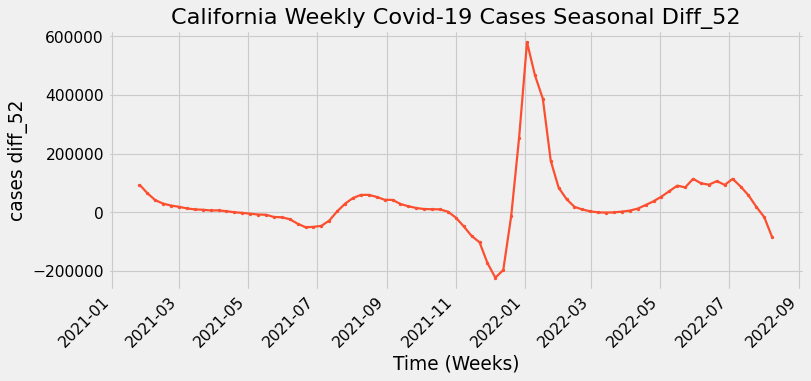

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


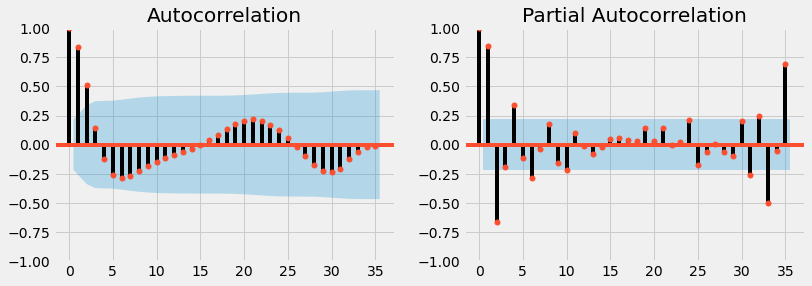


Dickey-Fuller test:
(-3.9775457065819375, 0.0015327617022115902, 5, 75, {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}, 1659.9516799790733)
p-value: 0.0015327617022115902
The null hypothesis can be rejected. The time-series is stationary. (0.0015 < 0.05)


In [21]:
# Seasonal Transformation
# plot information
data_plot = data_seasondiff.loc[:, 'cases']
tranformation_type = f'Seasonal Diff_{season}'
y_label_name = f'cases diff_{season}'
color_plot = '#fc4f30' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
adf_pvalue = result[1]

print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {adf_pvalue}')
dickey_fuller_test_results(adf_pvalue)

### Stationarity
The data is still stationary according to the Dickey-Fuller test with the season differencing.  The ACF is still showing some seasonality. The pACF has much more significant lags and noise around 20 lags.

In [22]:
_ = eacf(data_plot)

AR / MA
  0  1  2  3  4  5  6  7  8  9  10 11 12 13
0  x  x  o  o  x  x  x  o  o  o  o  o  o  o
1  x  x  o  o  x  o  o  o  o  o  o  o  o  o
2  o  x  x  o  o  o  o  o  o  o  o  o  o  o
3  x  x  x  o  o  o  o  o  o  o  o  o  o  o
4  x  x  x  o  o  o  o  o  o  o  o  o  o  o
5  x  x  o  x  o  o  o  o  o  o  o  o  o  o
6  o  x  o  x  o  o  o  o  o  o  o  o  o  o
7  o  o  x  x  o  o  o  o  o  o  o  o  o  o


Seasonality might exist in data. Will try a model will seasonal differencing

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


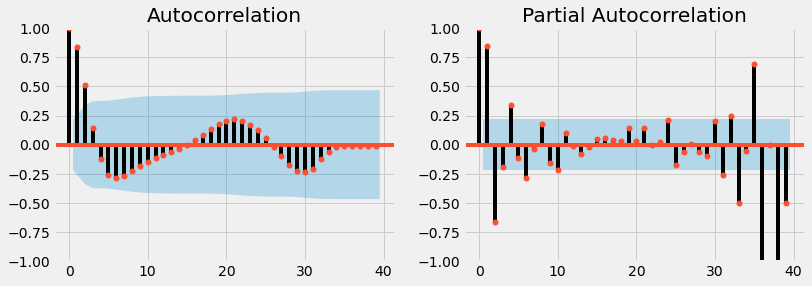

In [23]:
# Season Difference
# acf pacf plts
fig, ax = plt.subplots(1,2,figsize= (12,4))
# acf
sm.graphics.tsa.plot_acf(data_seasondiff.values.squeeze(), lags=39, ax=ax[0], color=color_plot)
#sm.graphics.tsa.plot_acf(data.values.squeeze(), ax=ax[0], color=color_plot)
# pacf
sm.graphics.tsa.plot_pacf(data_seasondiff, lags=39, ax=ax[1], color=color_plot)
plt.show()

### Augmented Dickey Fuller Test
Test p-value for stationarity

In [24]:
df_stationary_pval = pd.DataFrame(stationary_pvalue_map)
display(df_stationary_pval)

,Transformation,Pvalue
0,Weekly,0.00001


Data appears to be already stationary. Will try with one seasonal difference

## Data Train, Test, Validation Split
Split data into test, train and validation groups. Roughly an 80/20 split

In [25]:
# Set Data
#data = df_cal_cases.loc[:, ["date", "cases"]].set_index(['date'])
data = data_weekly.copy()
print(f'Data Shape: {data.shape}')

Data Shape: (133, 1)


In [26]:
# Test Train split
val_size = 15
test_size = 13
data_train = data.iloc[:-(val_size + test_size), :]
data_val = data.iloc[-(val_size + test_size):-test_size]
data_test = data.iloc[-test_size:, :]
data_train_val = data.iloc[:-test_size, :]
print(f'Train Data Shape: {data_train.shape}')
print(f'Validation Data Shape: {data_val.shape}')
print(f'Train + Validation Data Shape: {data_train_val.shape}')
print(f'Test Data Shape: {data_test.shape}')

Train Data Shape: (105, 1)
Validation Data Shape: (15, 1)
Train + Validation Data Shape: (120, 1)
Test Data Shape: (13, 1)


### Replot time series to find insights

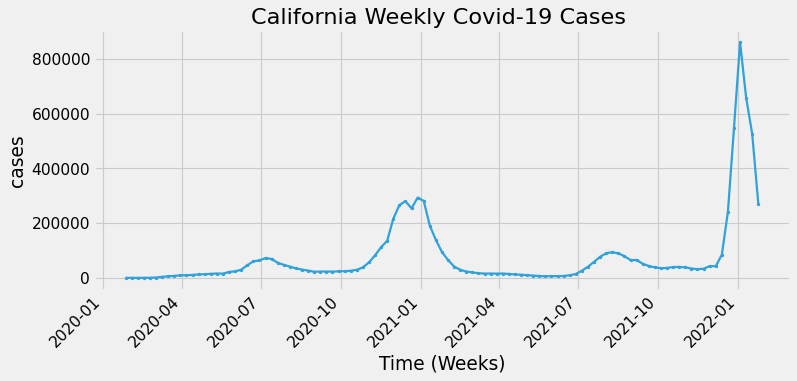

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


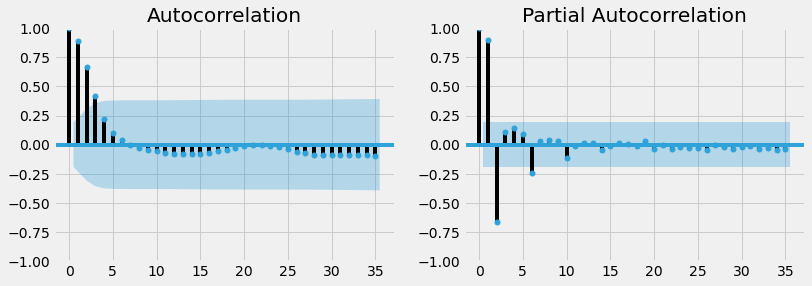


Dickey-Fuller test:
(-5.023797379258587, 1.9908146016449576e-05, 1, 103, {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}, 2232.3263235661525)
p-value: 1.9908146016449576e-05


In [27]:
# No Tranformation
# plot information
data_plot = data_train.loc[:, 'cases']
tranformation_type = ''
y_label_name = 'cases'
color_plot = '#30a2da' 

# plot
covid_plot_ts_acf_pacf(
    data = data_plot, 
    tranformation_type= tranformation_type, 
    x_label_name = x_label_name, 
    y_label_name = y_label_name, 
    data_type_name= data_type_name, 
    color_plot = color_plot)


# Stationarity Test
result = adfuller(data_plot)
print('\nDickey-Fuller test:')
print(result)
print(f'p-value: {result[1]}')

# Model Selection
The python package "pmdarima" was used to select the model. Ran pmdarima which is a pythom ARIMA model parameter selection package. The package minimizes the AIC of a model. Input starting parameters for a SARIMA model. Ran it once with no seasonal difference and once with one seasonal difference. The results were the following
SARIMA(5,0,1)x(1,1,1)[52]

SARIMA(4,0,1)x(0,1,0)[52]

SARIMA(3,0,0)x(1,1,1)[52]

SARIMA(2,0,0)x(1,0,0)[52]



```
# AIC Minimizaion
model= pm.auto_arima(
    data_train, 
    start_p=2,d=0,start_q=0, 
    max_p=5,max_d=1,max_q=3, 
    start_P=1, D=0, start_Q=0, 
    max_P=5,max_D=1, max_Q=3, m=season, 
    seasonal=True, error_action='warn',trace=True, supress_warnings=True,stepwise=True, random_state=20,n_fits=50)
```



In [28]:
model_names = []
aic_list = []
bic_list = []
llf_list = []

#### SARIMA(5,0,0)x(1,1,1)[52]

In [29]:
model_seasdiff = pm.arima.ARIMA(order=(5,0,0), seasonal_order=(1, 1, 1, 52)).fit(data_train)
model_seasdiff.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  105
Model:             SARIMAX(5, 0, 0)x(1, 1, [1], 52)   Log Likelihood                -640.731
Date:                              Fri, 12 Aug 2022   AIC                           1299.461
Time:                                      18:32:03   BIC                           1317.194
Sample:                                           0   HQIC                          1306.280
                                              - 105                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8733.1625   2.68e+04      0.326      0.744   -4.38e+04    6.13e+04
ar.L1          1.5712      0.193      8.152      0.000       1.193       1.949
ar.L2         -0.4809      0.271     -1.775      0.076      -1.012       0.050
ar.L3         -1.0977      0.427     -2.573      0.010      -1.934      -0.262
ar.L4          1.3635      0.823      1.657      0.098      -0.249       2.976
ar.L5         -0.5882      0.498     -1.182      0.237      -1.564       0.387
ar.S.L52       0.3775      0.481      0.786      0.432      -0.564       1.319
ma.S.L52       0.3587      0.420      0.853      0.394      -0.465       1.183
sigma2      1.995e+09      0.160   1.24e+10      0.000       2e+09       2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               118.88
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              35.40   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+25. Standard errors may be unstable.
"""

AR lags 4 and 5 are not significant. Seasonal AR and MA lags are also not significant. This model experience overfitting on the dataset and is not useful.

#### SARIMA(4,0,1)x(0,1,0)[52]

In [30]:
model_seasdiff = pm.arima.ARIMA(order=(4,0,1), seasonal_order=(0, 1, 0, 52)).fit(data_train)
display(model_seasdiff.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  105
Model:             SARIMAX(4, 0, 1)x(0, 1, [], 52)   Log Likelihood                -645.913
Date:                             Fri, 12 Aug 2022   AIC                           1305.826
Time:                                     18:32:09   BIC                           1319.618
Sample:                                          0   HQIC                          1311.130
                                             - 105                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4509.2292    2.7e+04      0.167      0.868   -4.85e+04    5.75e+04
ar.L1          0.7657      0.951      0.805      0.421      -1.098       2.629
ar.L2          0.5419      1.106      0.490      0.624      -1.625       2.709
ar.L3         -0.9665      0.394     -2.454      0.014      -1.739      -0.194
ar.L4          0.2559      0.834      0.307      0.759      -1.378       1.890
ma.L1          0.6658      0.913      0.729      0.466      -1.125       2.456
sigma2      2.485e+09      0.087   2.84e+10      0.000    2.48e+09    2.48e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               123.30
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              99.34   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.64e+27. Standard errors may be unstable.
"""

AR lags 1, 2, and 4 are do not have significant p-vales. MA lag 1 is also not significant.

In [31]:
model_seasdiff = pm.arima.ARIMA(order=(2,0,1), seasonal_order=(0, 1, 0, 52)).fit(data_train)
display(model_seasdiff.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  105
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 52)   Log Likelihood                -648.569
Date:                             Fri, 12 Aug 2022   AIC                           1307.137
Time:                                     18:32:11   BIC                           1316.988
Sample:                                          0   HQIC                          1310.925
                                             - 105                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5097.5773   8759.973      0.582      0.561   -1.21e+04    2.23e+04
ar.L1          1.6080      0.097     16.535      0.000       1.417       1.799
ar.L2         -0.8940      0.108     -8.259      0.000      -1.106      -0.682
ma.L1         -0.2273      0.150     -1.519      0.129      -0.521       0.066
sigma2      2.442e+09      0.041   5.95e+10      0.000    2.44e+09    2.44e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               103.26
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              17.48   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.15e+28. Standard errors may be unstable.
"""

ma.L1 is still not siginifcant. There is not moving average in this model

In [46]:
model_seasdiff = pm.arima.ARIMA(order=(3,0,0), seasonal_order=(0, 1, 0, 52)).fit(data_train)
display(model_seasdiff.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -648.050
Date:                            Fri, 12 Aug 2022   AIC                           1306.101
Time:                                    18:47:00   BIC                           1315.952
Sample:                                         0   HQIC                          1309.889
                                            - 105                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5097.5788   1.07e+04      0.475      0.635    -1.6e+04    2.62e+04
ar.L1          1.3283      0.078     16.948      0.000       1.175       1.482
ar.L2         -0.4378      0.154     -2.836      0.005      -0.740      -0.135
ar.L3         -0.2626      0.135     -1.948      0.051      -0.527       0.002
sigma2      2.411e+09      0.062   3.92e+10      0.000    2.41e+09    2.41e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.95
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              15.05   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.7e+26. Standard errors may be unstable.
"""

In [33]:
model_names.append('SARIMA(3,0,0)x(0,1,0)[52]')
aic_list.append(model_seasdiff.aic())
bic_list.append(model_seasdiff.bic())
#llf_list.append(model_seasdiff.llf)

##### Final model: SARIMA(2,0,0)x(0,1,0)[52]

All coeficients are significnat the AIC is 1307.


#### SARIMA(2,0,0)x(1,0,0)[52]

In [34]:
model_noseasdiff = pm.arima.ARIMA(order=(2,0,0), seasonal_order=(1, 0, 0, 52)).fit(data_train)
display(model_noseasdiff.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -1276.226
Date:                            Fri, 12 Aug 2022   AIC                           2562.452
Time:                                    18:32:14   BIC                           2575.722
Sample:                                         0   HQIC                          2567.829
                                            - 105                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.323e+04   1.22e+04      1.082      0.279   -1.07e+04    3.72e+04
ar.L1          1.4859      0.032     46.660      0.000       1.423       1.548
ar.L2         -0.7035      0.035    -20.343      0.000      -0.771      -0.636
ar.S.L52       0.2904      0.132      2.197      0.028       0.031       0.549
sigma2      2.201e+09      0.122    1.8e+10      0.000     2.2e+09     2.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1068.98
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):              26.30   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.61e+25. Standard errors may be unstable.
"""

In [35]:
model_names.append('SARIMA(2,0,0)x(1,0,0)[52]')
aic_list.append(model_noseasdiff.aic())
bic_list.append(model_noseasdiff.bic())
#llf_list.append(model_seasdiff.llf)

##### Final model: SARIMA(2,0,0)x(1,0,0)[52]

All coeficients are significnat the AIC is 2562.


#### AR(2)

In [36]:
model_ar = pm.arima.ARIMA(order=(2,0,0), seasonal_order=(0, 0, 0, 52)).fit(data_train)
display(model_ar.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1278.941
Date:                Fri, 12 Aug 2022   AIC                           2565.882
Time:                        18:32:14   BIC                           2576.497
Sample:                             0   HQIC                          2570.183
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.323e+04   9070.757      1.459      0.145   -4545.433     3.1e+04
ar.L1          1.4919      0.029     51.515      0.000       1.435       1.549
ar.L2         -0.6786      0.035    -19.606      0.000      -0.746      -0.611
sigma2      2.201e+09      0.601   3.66e+09      0.000     2.2e+09     2.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1359.54
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              55.79   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+32. Standard errors may be unstable.
"""

In [37]:
model_names.append('AR(2)')
aic_list.append(model_ar.aic())
bic_list.append(model_ar.bic())
#llf_list.append(model_seasdiff.llf)

#### Model Comparison

In [38]:
#pd.DataFrame({'model' : model_names, 'aic' : aic_list, 'bic' : bic_list, 'llf' : llf_list})
pd.DataFrame({'model' : model_names, 'aic' : aic_list, 'bic' : bic_list})

,model,aic,bic
0,"SARIMA(3,0,0)x(0,1,0)[52]",1306.100966,1315.952426
1,"SARIMA(2,0,0)x(1,0,0)[52]",2562.452309,2575.722110
2,AR(2),2565.881571,2576.497413


# Models

SARIMA(2, 0, 0)x(1,0,0)[52]

SARIMA(3, 0, 0)x(0,1,0)[52]


In [39]:
# Variables
pdqParams_list = [
    (2, 0 , 0),
    (3, 0,  0),
]

PDQParams_list = [
    (1, 0, 0, season),
    (0, 1, 0, season),
]

model_names = [
    'SARMA(2,0)x(1,0)[52]', 
    'SARIMA(3,0,0)x(0,1,0)[52]',
    ]

true_color = '#30a2da'
line_color_list = ['#fc4f30', '#6d904f', '#e5ae38'] # old color: #e5ae38, new color: #6d904f
line_pred_style = '--'


model_list = []
df_accuracy_metrics = pd.DataFrame()

# model names
model_names2 = []
for inc, pdqParams in enumerate(pdqParams_list):
  model_names2.append(f'SARIMAX{pdqParams}x{PDQParams_list[inc]}')


### K-folds Cross validation

k=0, Train Size: (20,), Val Size: (17,)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.

k=1, Train Size: (37,), Val Size: (17,)
k=2, Train Size: (54,), Val Size: (17,)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informat

k=3, Train Size: (71,), Val Size: (17,)
k=4, Train Size: (88,), Val Size: (17,)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informat

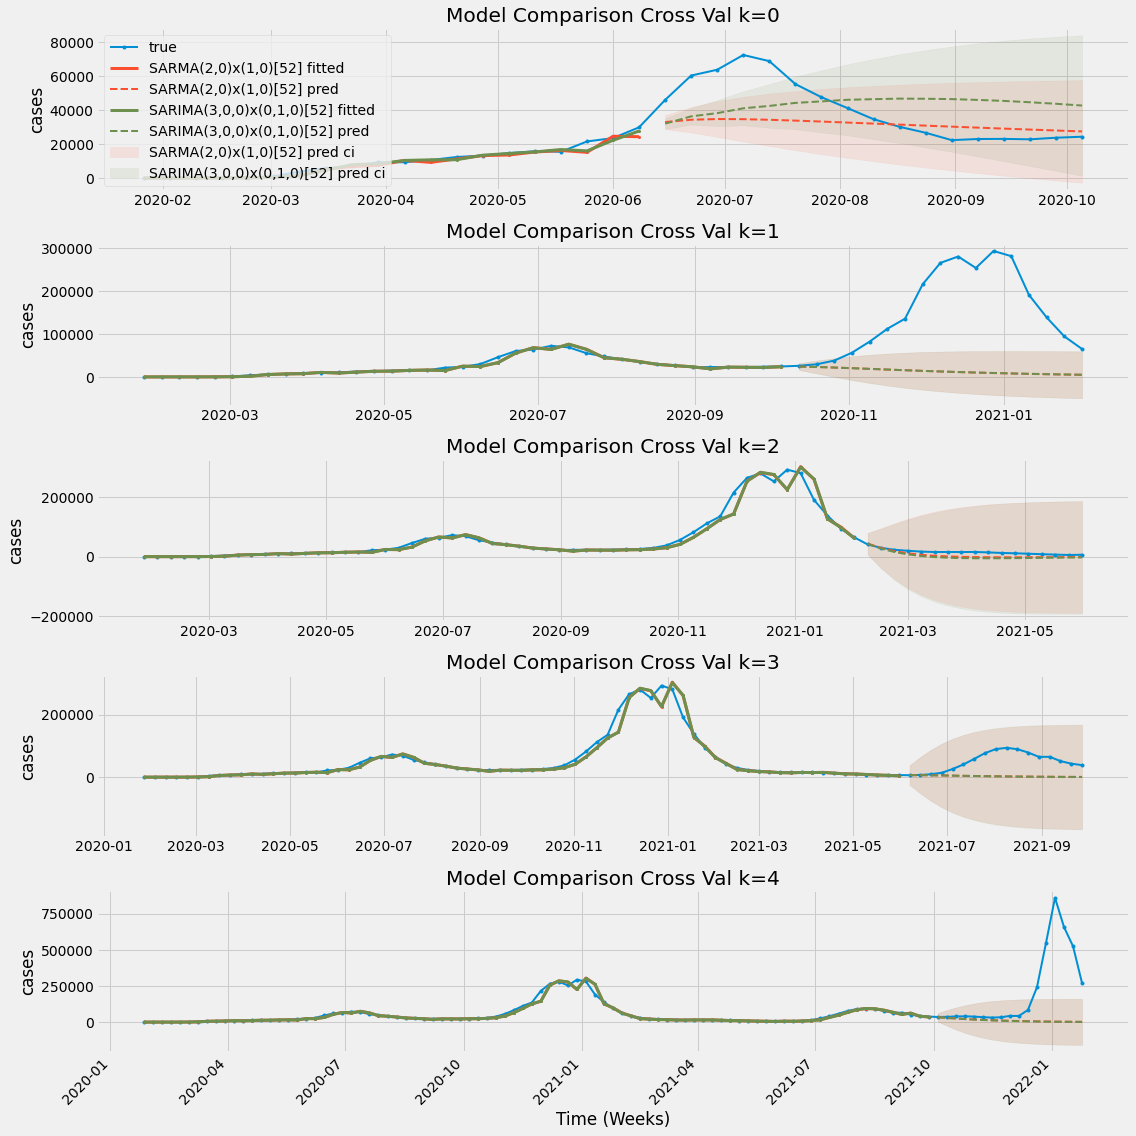

,model,k,mape,mae,mpe,rmse,corr,minmax,aic,bic,llf
0,"SARMA(2,0)x(1,0)[52]",0,0.284,13318.260,-0.088,17609.300,NaN,0.265,373.81,376.79,-183.90
1,"SARIMA(3,0,0)x(0,1,0)[52]",0,0.560,18680.665,0.305,20129.267,NaN,0.365,367.54,371.53,-179.77
2,"SARMA(2,0)x(1,0)[52]",1,0.787,137030.376,-0.787,168736.359,NaN,0.787,725.97,730.81,-359.99
3,"SARIMA(3,0,0)x(0,1,0)[52]",1,0.787,136938.365,-0.787,168634.155,NaN,0.787,728.03,734.47,-360.02
4,"SARMA(2,0)x(1,0)[52]",2,0.870,10418.019,-0.862,11445.527,NaN,0.870,1221.57,1227.54,-607.78
5,"SARIMA(3,0,0)x(0,1,0)[52]",2,1.092,13261.854,-1.086,14480.494,NaN,1.091,1223.57,1231.53,-607.79
6,"SARMA(2,0)x(1,0)[52]",3,0.795,47075.006,-0.789,56225.213,NaN,0.795,1583.80,1590.59,-788.90
7,"SARIMA(3,0,0)x(0,1,0)[52]",3,0.798,47181.622,-0.792,56333.236,NaN,0.798,1585.79,1594.84,-788.90
8,"SARMA(2,0)x(1,0)[52]",4,0.698,197015.501,-0.698,331721.916,NaN,0.698,1945.32,1952.75,-969.66
9,"SARIMA(3,0,0)x(0,1,0)[52]",4,0.714,197959.114,-0.714,332331.859,NaN,0.714,1947.28,1957.19,-969.64


In [40]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=None) # test_size=60

df_acc_comparison_k = pd.DataFrame()

plt.figure(figsize=(16, 16))
for k,( tr_idx, val_idx) in enumerate(tscv.split(data_train)):
  print(f'k={k}, Train Size: {tr_idx.shape}, Val Size: {val_idx.shape}')
  data_train_k, data_val_k = data_train.iloc[tr_idx, :], data_train.iloc[val_idx, :]

  # true values to validate prediction
  y_true = data_val_k.values

  # lists
  model_list = []
  data_pred_list = []
  pred_ci_list = []

  # loop through models
  
  for inc, pdqParams in enumerate(pdqParams_list):

    # fit model
    model = SARIMAX(data_train_k, order=pdqParams, season=PDQParams_list[inc]).fit()
    model_list.append(model)

    # forecast
    #data_pred_k = pd.Series(model.forecast(len(data_val_k))[0], index= data_val_k.index)
    data_pred_k = model.forecast(len(data_val_k))
    fcast = model.get_forecast(len(data_val_k))
    ci = fcast.conf_int()
    pred_ci_list.append(ci)
    data_pred_list.append(data_pred_k)
    y_pred = data_pred_k.values

    # measure accuracy
    acc_dict = find_prediction_acc(y_pred, y_true, print_result=False)
    acc_dict['aic'] = round(model.aic, 2)
    acc_dict['bic'] = round(model.bic, 2)
    acc_dict['llf'] = round(model.llf, 2)
    acc_dict['model'] = model_names[inc]
    acc_dict['k'] = k

    df_acc_comparison_k = df_acc_comparison_k.append(pd.DataFrame(acc_dict, index=[inc]))


  # Plot
  plt.subplot(n_splits,1, (k+1))
  plt.plot(pd.concat([data_train_k, data_val_k], axis=0), marker='o', markersize=3, linewidth=2, label= 'true')
  for inc, model in enumerate(model_list):
    plt.plot(model.fittedvalues, marker='o', markersize=2, linewidth=3, color=line_color_list[inc], label= f'{model_names[inc]} fitted')
    plt.plot(data_pred_list[inc], line_pred_style, markersize=3, linewidth=2, color=line_color_list[inc], label= f'{model_names[inc]} pred')
    # plot confidence interval
    ci = pred_ci_list[inc]
    plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color=line_color_list[inc], alpha=0.1, label = f'{model_names[inc]} pred ci')
  plt.title(f'Model Comparison Cross Val k={k}')
  if (k+1) == n_splits:
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Time (Weeks)')
  plt.ylabel('cases')

  if k == 0:
    plt.legend( loc='upper left')

plt.tight_layout()
plt.show()


df_acc_comparison_k = df_acc_comparison_k.reset_index(drop=True)
df_acc_comparison_k = pd.concat([df_acc_comparison_k.iloc[:, -2:], df_acc_comparison_k.iloc[:, :-2]], axis=1)
df_accuracy_metrics = df_accuracy_metrics.append(df_acc_comparison_k)
display(df_acc_comparison_k)

Models are very similar. It does not seem like the seasonal difference is enhancing the model

In [41]:
# Averages
df_acc_k_avg = df_acc_comparison_k.groupby(['model']).mean().round(2).reset_index()
df_acc_k_avg.loc[:,'k'] = 'k_avg'
display(df_acc_k_avg)
df_accuracy_metrics = df_accuracy_metrics.append(df_acc_k_avg)

,model,k,mape,mae,mpe,rmse,corr,minmax,aic,bic,llf
0,"SARIMA(3,0,0)x(0,1,0)[52]",k_avg,0.79,82804.32,-0.61,118381.80,NaN,0.75,1170.44,1177.91,-581.22
1,"SARMA(2,0)x(1,0)[52]",k_avg,0.69,80971.43,-0.64,117147.66,NaN,0.68,1170.09,1175.70,-582.05


The models are so close in aic and bic values over the k-folds cross validation.

### Use Training Data
Train on train data and validate on validation data

SARMA(2,0)x{2,0)[52] vs SARIMA(3, 0, 0)x(0,1,0)[52]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informat

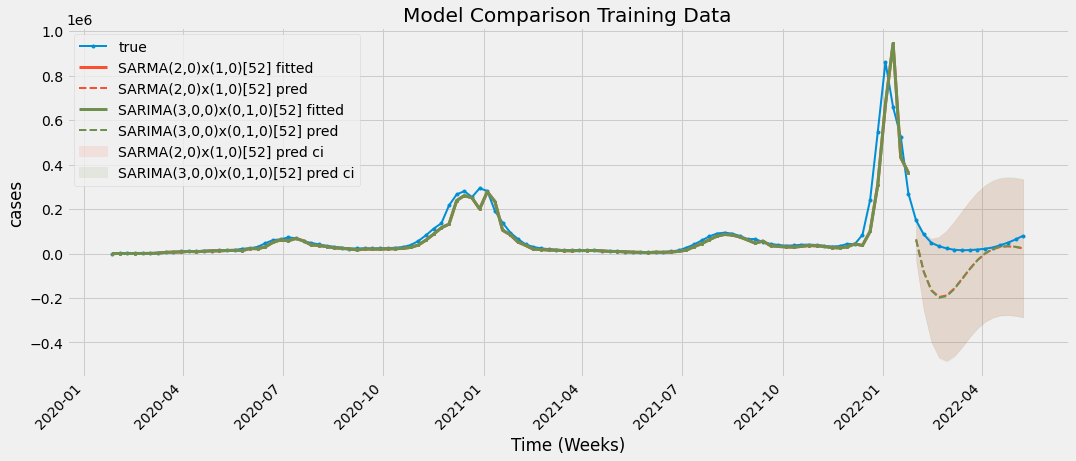

In [42]:
#  Training Data

# training data
y_true = data_val.values

# lists
df_acc_comparison_train = pd.DataFrame()
model_list = []
data_pred_list = []
pred_ci_list = []

for inc, pdqParams in enumerate(pdqParams_list):

  # fit model
  model = SARIMAX(data_train, order=pdqParams, season=PDQParams_list[inc]).fit()
  model_list.append(model)

  # forecast
  #data_pred = pd.Series(model.forecast(len(data_val))[0], index= data_val.index)
  data_pred = model.forecast(len(data_val))
  fcast = model.get_forecast(len(data_val))
  pred_ci_list.append(fcast.conf_int())
  data_pred_list.append(data_pred)
  y_pred = data_pred.values

  # measure accuracy
  acc_dict = find_prediction_acc(y_pred, y_true, print_result=False)
  acc_dict['aic'] = round(model.aic, 2)
  acc_dict['bic'] = round(model.bic, 2)
  acc_dict['llf'] = round(model.llf, 2)
  acc_dict['model'] = model_names[inc]
  acc_dict['k'] = 'train'

  df_acc_comparison_train = df_acc_comparison_train.append(pd.DataFrame(acc_dict, index=[inc]))


# Plot
#plt.subplot(n_splits,1, (k+1))
plt.figure(figsize=(16, 6))
plt.plot(pd.concat([data_train, data_val], axis=0), marker='o', markersize=3, linewidth=2, label= 'true')
for inc, model in enumerate(model_list):
  plt.plot(model.fittedvalues, marker='o', markersize=2, linewidth=3, color=line_color_list[inc], label= f'{model_names[inc]} fitted')
  plt.plot(data_pred_list[inc], line_pred_style, markersize=3, linewidth=2, color=line_color_list[inc], label= f'{model_names[inc]} pred')
  ci = pred_ci_list[inc]
  plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color=line_color_list[inc], alpha=0.1, label = f'{model_names[inc]} pred ci')
plt.title(f'Model Comparison Training Data')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Weeks)')
plt.ylabel('cases')

plt.legend()
#plt.tight_layout()
plt.show()



#### Validation vs. Prediction Plot

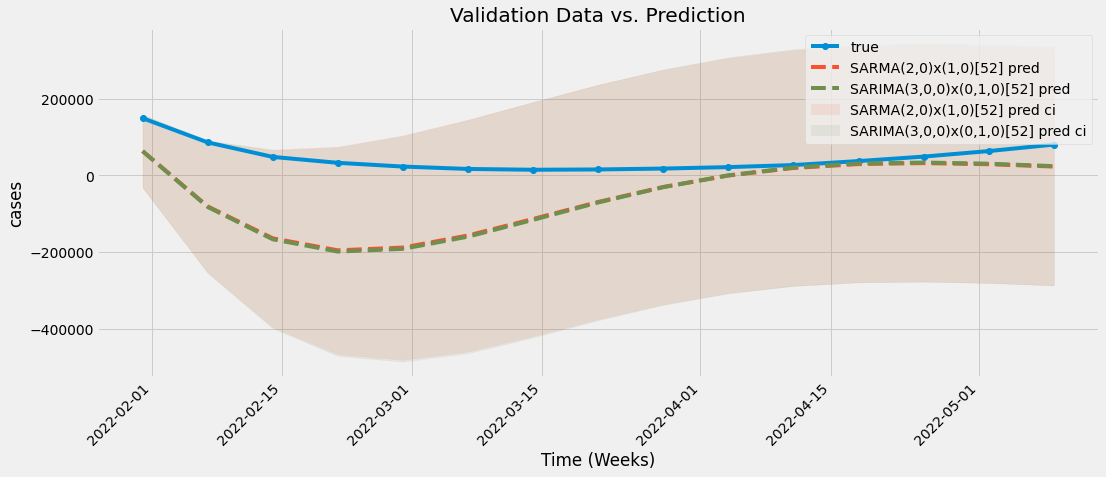

In [43]:
# Prediction plot
plt.figure(figsize=(16, 6))
plt.plot(pd.concat([data_val], axis=0), marker='o',label= 'true')
for inc, model in enumerate(model_list):
  #plt.plot(model.fittedvalues, marker='o', markersize=2, linewidth=3, color=line_color_list[inc], label= f'{model_names[inc]} fitted')
  plt.plot(data_pred_list[inc], line_pred_style, color=line_color_list[inc], label= f'{model_names[inc]} pred')
  ci = pred_ci_list[inc]
  plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color=line_color_list[inc], alpha=0.1, label = f'{model_names[inc]} pred ci')
plt.title(f'Validation Data vs. Prediction')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Weeks)')
plt.ylabel('cases')


plt.legend()
#plt.tight_layout()
plt.show()


In [44]:
df_acc_comparison_train = df_acc_comparison_train.reset_index(drop=True)
df_acc_comparison_train = pd.concat([df_acc_comparison_train.iloc[:, -2:], df_acc_comparison_train.iloc[:, :-2]], axis=1)
df_accuracy_metrics = df_accuracy_metrics.append(df_acc_comparison_train)
display(df_acc_comparison_train)

,model,k,mape,mae,mpe,rmse,corr,minmax,aic,bic,llf
0,"SARMA(2,0)x(1,0)[52]",train,3.574,98979.493,-3.574,126039.902,NaN,3.574,2569.85,2577.81,-1281.93
1,"SARIMA(3,0,0)x(0,1,0)[52]",train,3.613,99710.185,-3.613,127668.691,NaN,3.613,2571.87,2582.49,-1281.94


SARIMA(2,0,0)x(2,0,0) seems to make a good comparison. The seasonal difference is not enhancing the model.  Will remove the model.

# Residual Analysis Comparison

In [47]:
residual_map = {}

In [48]:
# Summary
for inc, model in enumerate(model_list):
  print(f'{model_names[inc]}')
  display(model.summary())
  print('\n\n')

SARMA(2,0)x(1,0)[52]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  105
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1281.926
Date:                Fri, 12 Aug 2022   AIC                           2569.852
Time:                        18:49:52   BIC                           2577.814
Sample:                    01-27-2020   HQIC                          2573.078
                         - 01-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5141      0.027     56.355      0.000       1.461       1.567
ar.L2         -0.6563      0.039    -16.719      0.000      -0.733      -0.579
sigma2      2.333e+09   3.46e-12   6.74e+20      0.000    2.33e+09    2.33e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1914.66
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             210.78   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+36. Standard errors may be unstable.
"""




SARIMA(3,0,0)x(0,1,0)[52]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  105
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1281.937
Date:                Fri, 12 Aug 2022   AIC                           2571.874
Time:                        18:49:52   BIC                           2582.490
Sample:                    01-27-2020   HQIC                          2576.176
                         - 01-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5119      0.038     40.083      0.000       1.438       1.586
ar.L2         -0.6505      0.082     -7.932      0.000      -0.811      -0.490
ar.L3         -0.0043      0.062     -0.069      0.945      -0.126       0.117
sigma2      2.356e+09   3.85e-11   6.12e+19      0.000    2.36e+09    2.36e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1930.20
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             209.79   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.54e+34. Standard errors may be unstable.
"""


SARMA(2,0)x(1,0)[52]


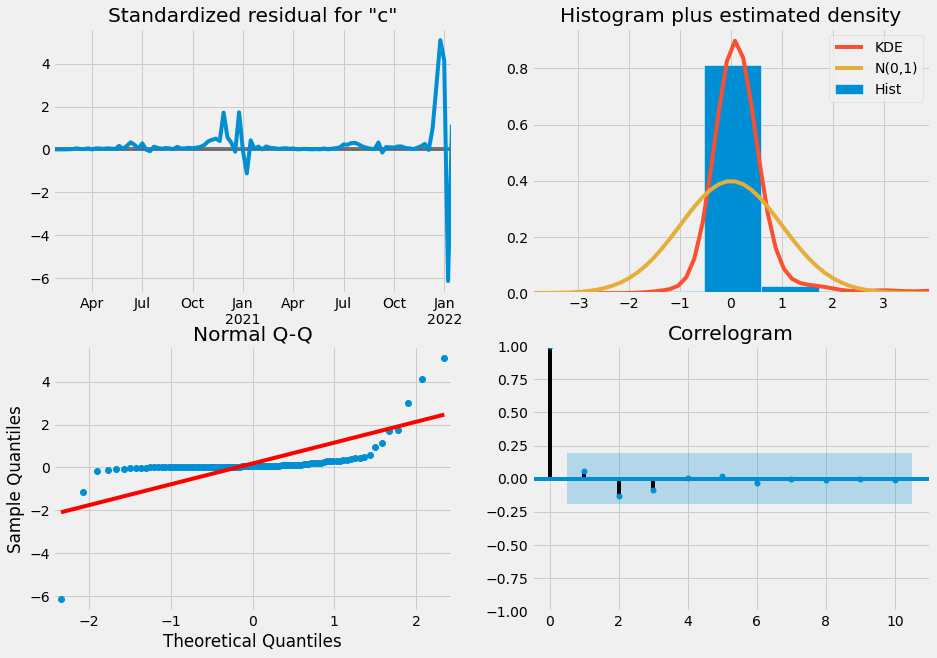


SARIMA(3, 0, 0)X(1, 1, 1)[52]


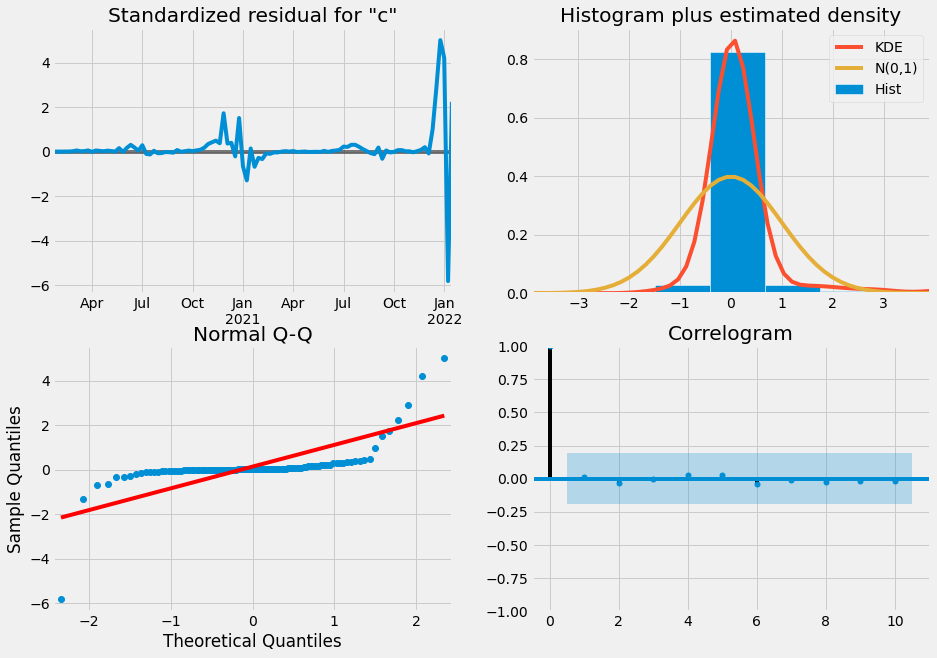

In [51]:
for inc, model in enumerate(model_list):
  print(f'\n{model_names[inc]}')
  model.plot_diagnostics(figsize=(14, 10))
  plt.show()

There are some volatile residuals and massive outliers. The residuals do not seem to experience normality from the qq-plot. 

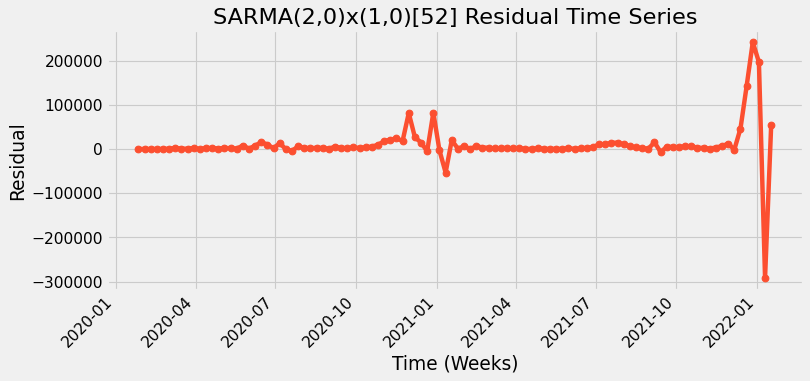

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


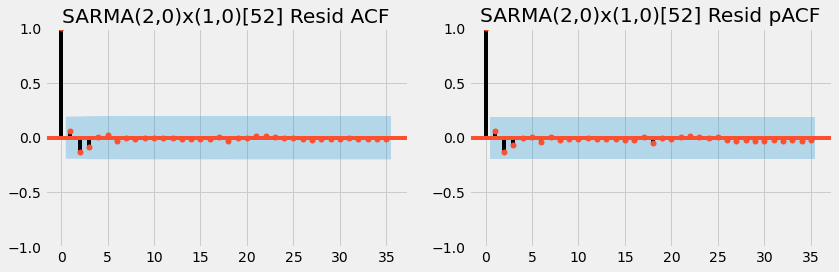

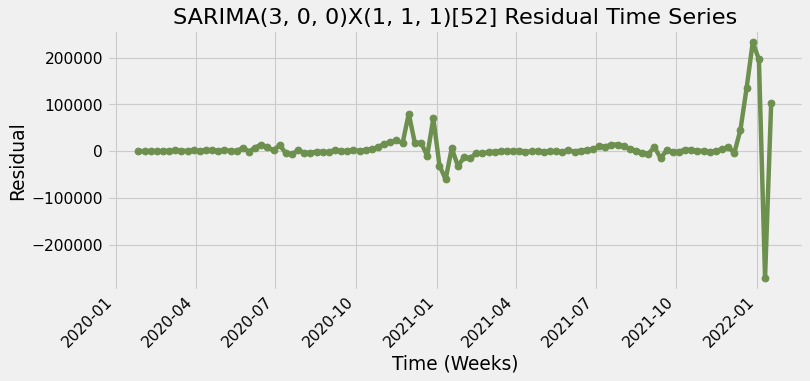

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


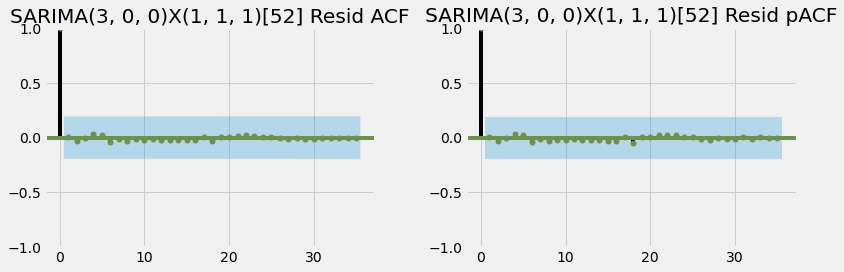

In [52]:
for inc, model in enumerate(model_list):
  model_resid_map = {}
  df_model_residuals  = pd.DataFrame(model.resid)
  
  #df_model_residuals.plot()
  #df_model_residuals.plot(kind='kde')
  #plt.title(f'ARIMA{pdqParmas_list[inc]} Residuals')
  #plt.show()
  
  # Plot Resiudals
  ts_fig_size = (10, 4)
  acf_pacf_fig_size = (12,4)

  #Plot Time Series
  plt.figure(figsize= ts_fig_size, dpi=80)
  plt.plot( df_model_residuals, marker='o', color=line_color_list[inc])
  plt.title(f'{model_names[inc]} Residual Time Series')
  plt.xticks(rotation=45, ha='right')
  plt.xlabel('Time (Weeks)')
  plt.ylabel('Residual')
  plt.show()


  # acf pacf plts
  fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
  # acf
  sm.graphics.tsa.plot_acf(df_model_residuals.values.squeeze(), lags=35, ax=ax[0], color=line_color_list[inc], title=f'{model_names[inc]} Resid ACF')
  # pacf
  sm.graphics.tsa.plot_pacf(df_model_residuals, lags=35, ax=ax[1], color=line_color_list[inc], title=f'{model_names[inc]} Resid pACF') 
  plt.tight_layout()
  plt.show()
  




All models are capturing the information

In [53]:
for inc, model in enumerate(model_list):
  print('\n')
  print(f'{model_names[inc]} Residuals')

  df_model_residuals  = pd.DataFrame(model.resid)
  display(df_model_residuals.describe())




SARMA(2,0)x(1,0)[52] Residuals


,0
count,104.000000
mean,8968.498254
std,46283.673697
min,-291332.798382
25%,717.581672
50%,2507.755300
75%,7773.324136
max,241551.341555




SARIMA(3, 0, 0)X(1, 1, 1)[52] Residuals


,0
count,104.000000
mean,6495.879846
std,45690.425796
min,-271103.519355
25%,-844.073734
50%,909.192162
75%,6717.860864
max,233174.231634


### Normality 

In [54]:
# Shapiro-Wilk
for inc, model in enumerate(model_list):
  print(f'\n\n{model_names[inc]}')
  shapiro_wilk_test(model.resid)

print()



SARMA(2,0)x(1,0)[52]
Shapiro-Wilk Test:
ShapiroResult(statistic=0.5224964618682861, pvalue=8.501084709462215e-17)
p-value: 0.0. The null-hypothesis can be rejected. The data is not normally distributed.


SARIMA(3, 0, 0)X(1, 1, 1)[52]
Shapiro-Wilk Test:
ShapiroResult(statistic=0.5224964618682861, pvalue=8.501084709462215e-17)
p-value: 0.0. The null-hypothesis can be rejected. The data is not normally distributed.



None of the models' residuals are experiencing normality. 

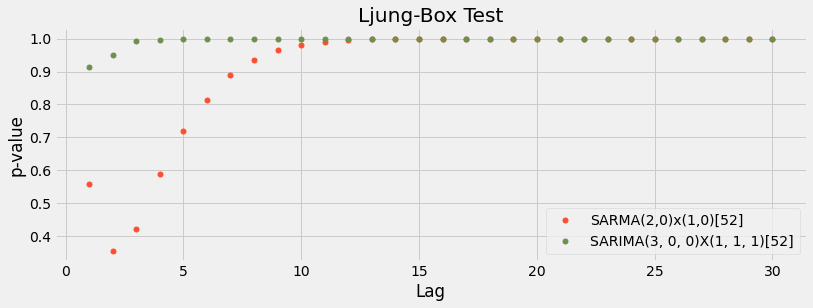

In [55]:
#Ljung Box Test

fig = plt.figure(figsize = (12, 4))
for inc, model in enumerate(model_list):
  print('\n\n')
  #print(f'{model_names[inc]}')
  lbt_array = sm.stats.acorr_ljungbox(pd.DataFrame(model.resid), lags=30)
  #display(lbt_array.tail(1))

  #plt.plot(lbt_array.lb_pvalue, marker='o', markersize=5, linewidth=0)
  plt.plot(lbt_array.lb_pvalue, marker='o', markersize=5, linewidth=0, color=line_color_list[inc], label= f'{model_names[inc]}')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title(f'Ljung-Box Test')
plt.legend()
plt.show()

### Standardize Residuals

<Figure size 864x288 with 0 Axes>

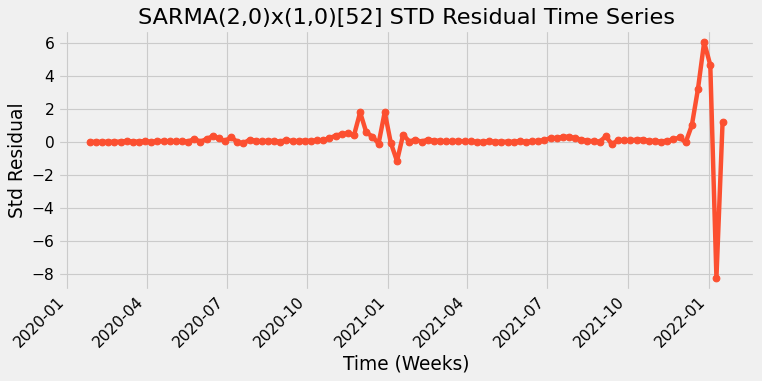

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


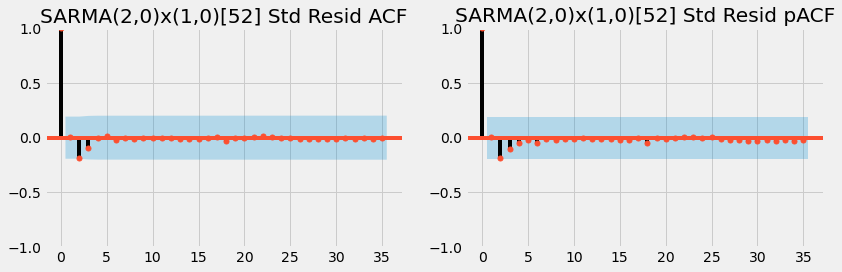

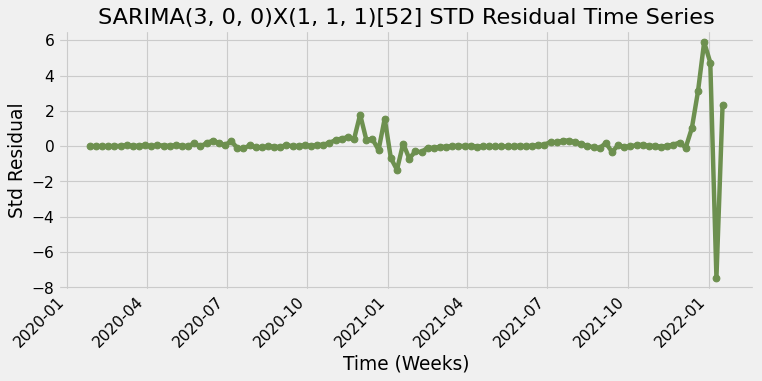

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


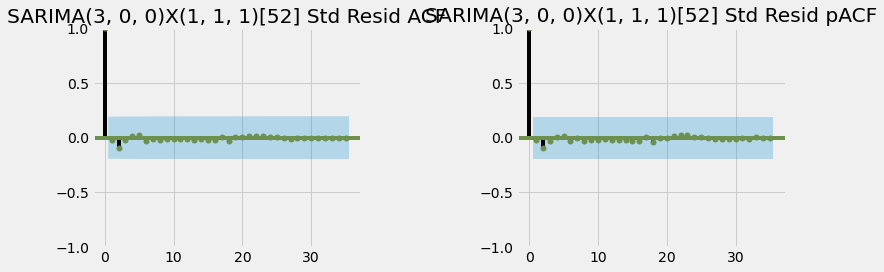

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


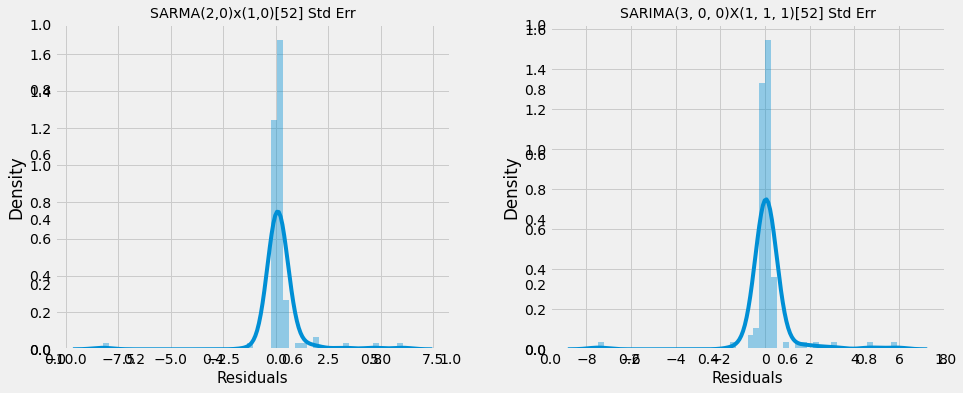

In [56]:
# Standardize Residuals
fig = plt.figure(figsize = (12, 4))
for inc, model in enumerate(model_list):
  #print('\n\n')
  #print(f'{model_names[inc]}')
  sqr_dev_mean = ((model.resid - model.resid.mean())**2).sum()
  ar_resid_leverage = 1/model.resid.count()+(model.resid- model.resid.mean())**2 / sqr_dev_mean

  std_residuals = model.resid/ (model.resid.std() * (1-ar_resid_leverage)**(1/2))

  # Plot Resiudals
  ts_fig_size = (10, 4)
  acf_pacf_fig_size = (12,4)

  #Plot Time Series
  plt.figure(figsize= ts_fig_size, dpi=80)
  plt.plot( std_residuals, marker='o', color=line_color_list[inc])
  plt.title(f'{model_names[inc]} STD Residual Time Series')
  plt.xticks(rotation=45, ha='right')
  plt.xlabel('Time (Weeks)')
  plt.ylabel('Std Residual')
  plt.show()


  # acf pacf plts
  fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
  # acf
  sm.graphics.tsa.plot_acf(std_residuals.values.squeeze(), lags=35, ax=ax[0], color=line_color_list[inc], title=f'{model_names[inc]} Std Resid ACF')
  # pacf
  sm.graphics.tsa.plot_pacf(std_residuals, lags=35, ax=ax[1], color=line_color_list[inc], title=f'{model_names[inc]} Std Resid pACF') 
  plt.tight_layout()
  plt.tight_layout() 
  plt.show()


fig, ax = plt.subplots(1,len(model_list), figsize= (14,6))
for inc, model in enumerate(model_list):
  sqr_dev_mean = ((model.resid - model.resid.mean())**2).sum()
  ar_resid_leverage = 1/model.resid.count()+(model.resid- model.resid.mean())**2 / sqr_dev_mean
  std_residuals = model.resid/ (model.resid.std() * (1-ar_resid_leverage)**(1/2))

  ax = fig.add_subplot(1,len(model_list), inc+1)
  sns.distplot(std_residuals) # you may select the no. of bins
  plt.title(f'{model_names[inc]} Std Err', fontsize=14)           
  plt.xlabel('Residuals', fontsize = 15) 
plt.tight_layout()    
plt.show()

In [57]:
display(df_accuracy_metrics) 

,model,k,mape,mae,mpe,rmse,corr,minmax,aic,bic,llf
0,"SARMA(2,0)x(1,0)[52]",0,0.388,19133.694,-0.388,24864.643,NaN,0.388,348.36,351.20,-171.18
1,"SARIMA(3, 0, 0)X(1, 1, 1)[52]",0,0.269,14230.781,-0.208,20133.078,NaN,0.265,348.17,351.94,-170.08
2,"SARMA(2,0)x(1,0)[52]",1,0.749,134695.783,-0.749,169032.555,NaN,0.749,707.60,712.35,-350.80
3,"SARIMA(3, 0, 0)X(1, 1, 1)[52]",1,0.749,134597.882,-0.749,168922.379,NaN,0.749,709.66,716.00,-350.83
4,"SARMA(2,0)x(1,0)[52]",2,0.985,12802.931,-0.985,14077.236,NaN,0.985,1200.11,1206.02,-597.06
5,"SARIMA(3, 0, 0)X(1, 1, 1)[52]",2,1.340,17950.250,-1.340,19474.379,NaN,1.340,1202.10,1209.98,-597.05
6,"SARMA(2,0)x(1,0)[52]",3,0.868,47037.022,-0.868,56959.358,NaN,0.868,1562.62,1569.37,-778.31
7,"SARIMA(3, 0, 0)X(1, 1, 1)[52]",3,0.872,47155.581,-0.872,57073.023,NaN,0.872,1564.62,1573.61,-778.31
8,"SARMA(2,0)x(1,0)[52]",4,0.705,184115.693,-0.705,326114.059,NaN,0.705,1924.31,1931.71,-959.16
9,"SARIMA(3, 0, 0)X(1, 1, 1)[52]",4,0.730,185432.029,-0.730,326806.094,NaN,0.730,1926.26,1936.13,-959.13


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


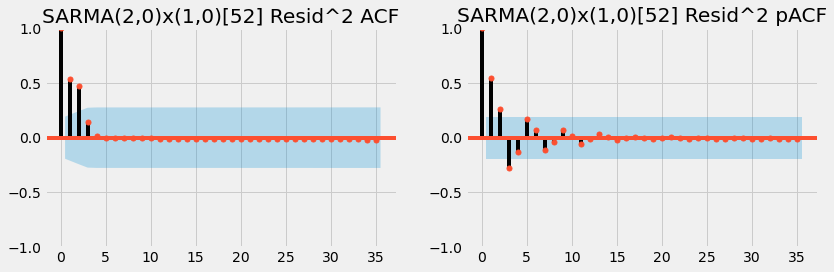

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


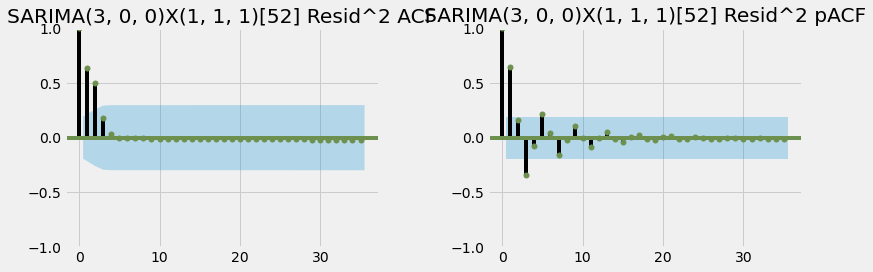

In [58]:
# Residuals Squared
for inc, model in enumerate(model_list):
  model_resid_map = {}
  resid_sqr = model.resid ** 2

  # acf pacf plts
  fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
  # acf
  sm.graphics.tsa.plot_acf(resid_sqr.values.squeeze(), lags=35, ax=ax[0], color=line_color_list[inc], title=f'{model_names[inc]} Resid^2 ACF')
  # pacf
  sm.graphics.tsa.plot_pacf(resid_sqr, lags=35, ax=ax[1], color=line_color_list[inc], title=f'{model_names[inc]} Resid^2 pACF') 
  plt.tight_layout()
  plt.show()





# Prediction

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


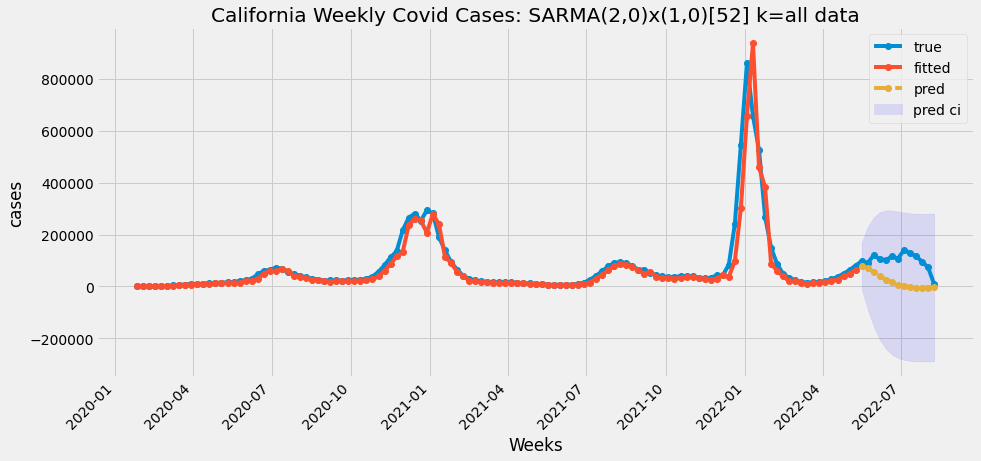

In [49]:
# SARIMA(p,d,q)X(P, D, Q)[s]
# SARIMA(3,0,0)X(1,1,1)[52]
#pdqParams = (3, 0, 0);  PDQParams = (1, 1, 1, season);  model_name = "SARIMA(3, 0, 0)x(1, 1, 1)[52]"

# SARIMA(2, 0, 0)X(1,0,0)[52]
pdqParams = (2, 0, 0);  PDQParams = (1, 0, 0, season);  model_name = "SARMA(2,0)x(1,0)[52]" 


df_acc_comp_final = pd.DataFrame()


# train + val
data_train_all = pd.concat([data_train, data_val], axis = 0)

df_acc_train_val = pd.DataFrame()
y_true = data_test.values

# fit model
model = SARIMAX(data_train_all, order=pdqParams, season_order= PDQParams).fit()

# forecast
#data_pred = pd.Series(model.forecast(len(data_test))[0], index= data_test.index)
data_pred = model.forecast(len(data_test))
fcast = model.get_forecast(len(data_test))
ci = fcast.conf_int()
y_pred = data_pred.values

# measure accuracy
acc_dict = find_prediction_acc(y_pred, y_true, print_result=False)
acc_dict['aic'] = round(model.aic, 2)
acc_dict['bic'] = round(model.bic, 2)
acc_dict['llf'] = round(model.llf, 2)
acc_dict['model'] = f'{model_names[inc]}'
acc_dict['k'] = 'train+val'
df_acc_comp_final = df_acc_comp_final.append(pd.DataFrame(acc_dict, index=[inc]))


# Plot
plt.figure(figsize=(14, 6))

# Loop
# AR Plot
#plt.subplot(len(model_list),1, (inc+1))
plt.plot(pd.concat([data_train_all, data_test], axis=0), marker='o', label= 'true')
plt.plot(model.fittedvalues, marker='o', label= 'fitted')
plt.plot(data_pred, line_pred_style, marker='o', label= 'pred')
plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color='blue', alpha=0.1, label = f'pred ci')
plt.title(f'California Weekly Covid Cases: {model_name} k=all data')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Weeks')
plt.ylabel('cases')

plt.legend()
plt.show()

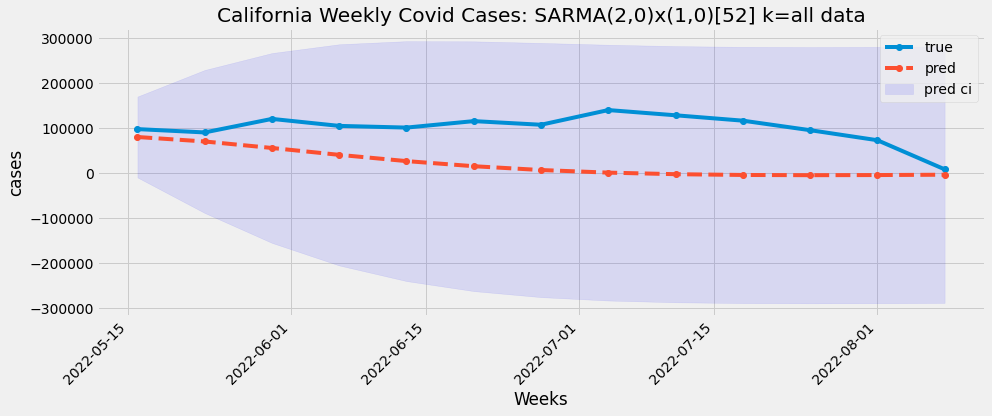

In [50]:
plt.figure(figsize=(14, 6))
plt.plot(pd.concat([data_test], axis=0), marker='o', label= 'true')
#plt.plot(model.fittedvalues, marker='o', label= 'fitted')
plt.plot(data_pred, line_pred_style, marker='o', label= 'pred')
plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color='blue', alpha=0.1, label = f'pred ci')
plt.title(f'California Weekly Covid Cases: {model_name} k=all data')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Weeks')
plt.ylabel('cases')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1458.655
Date:                Fri, 12 Aug 2022   AIC                           2923.309
Time:                        18:54:09   BIC                           2931.672
Sample:                    01-27-2020   HQIC                          2926.705
                         - 05-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4580      0.024     61.589      0.000       1.412       1.504
ar.L2         -0.5814      0.035    -16.691      0.000      -0.650      -0.513
sigma2      2.103e+09   5.78e-12   3.64e+20      0.000     2.1e+09     2.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2561.77
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             206.69   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.13e+35. Standard errors may be unstable.
"""

In [52]:
df_pred_comp = pd.concat([data_test, data_pred.round(1)],axis =1)
df_pred_comp.columns = ['True', 'Predicted']

display(df_pred_comp)

print('\nAccuracy')
df_accuracy_metrics = df_accuracy_metrics.append(df_acc_comp_final)
display(df_acc_comp_final)

,True,Predicted
2022-05-16,97763.0,80187.3
2022-05-23,90351.0,70253.7
2022-05-30,120418.0,55805.6
2022-06-06,104912.0,40516.0
2022-06-13,101125.0,26624.7
2022-06-20,115508.0,15261.1
2022-06-27,107432.0,6770.1
2022-07-04,140078.0,997.5
2022-07-11,128475.0,-2482.0
2022-07-18,116525.0,-4198.7



Accuracy


,mape,mae,mpe,rmse,corr,minmax,aic,bic,llf,model,k
1,0.822,78648.455,-0.822,88574.767,NaN,0.822,2923.31,2931.67,-1458.65,"SARIMA(3,0,0)x(0,1,0)[52]",train+val


# Final Residual Analysis

In [53]:
# Summary
print(model_name)
display(model.summary())


SARMA(2,0)x(1,0)[52]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1458.655
Date:                Fri, 12 Aug 2022   AIC                           2923.309
Time:                        19:15:32   BIC                           2931.672
Sample:                    01-27-2020   HQIC                          2926.705
                         - 05-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4580      0.024     61.589      0.000       1.412       1.504
ar.L2         -0.5814      0.035    -16.691      0.000      -0.650      -0.513
sigma2      2.103e+09   5.78e-12   3.64e+20      0.000     2.1e+09     2.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2561.77
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             206.69   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.13e+35. Standard errors may be unstable.
"""


SARMA(2,0)x(1,0)[52]


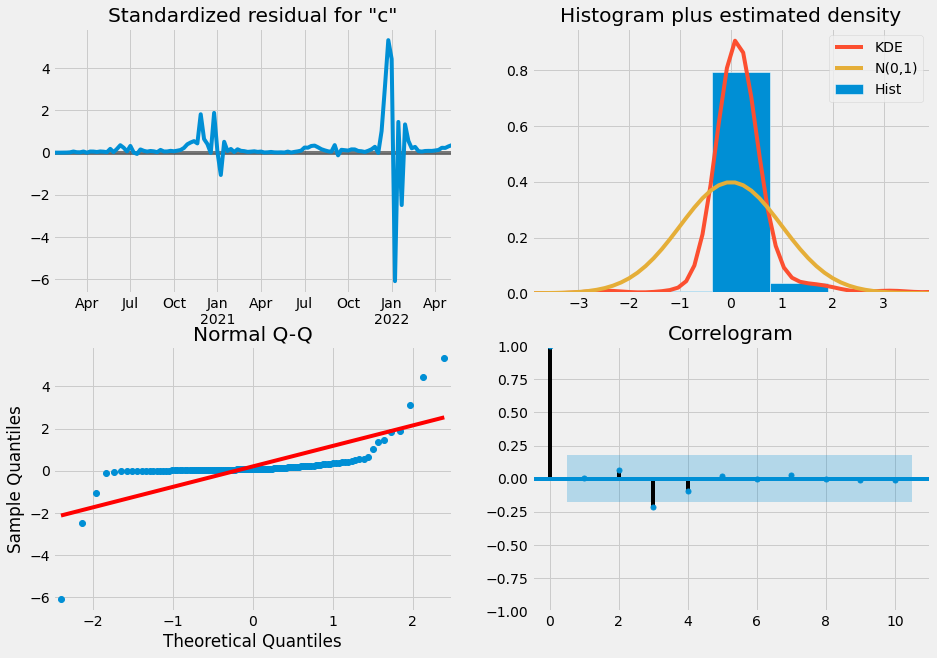

In [54]:
print(f'\n{model_name}')
model.plot_diagnostics(figsize=(14, 10))
plt.show()

,0
count,120.000000
mean,9337.256323
std,44701.454423
min,-279345.719853
25%,1430.532325
50%,3592.974380
75%,10291.850238
max,244513.857106


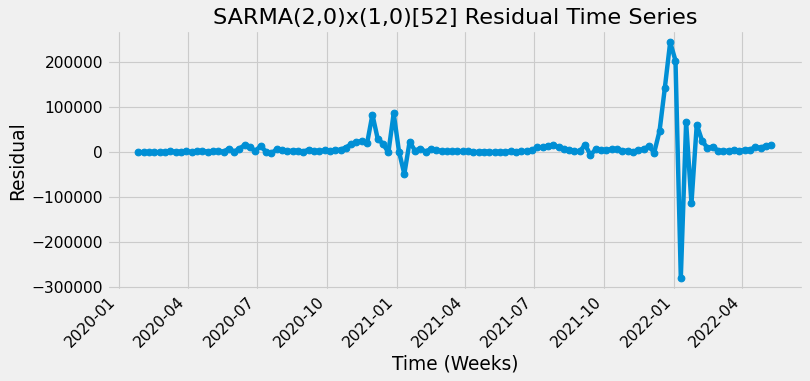

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


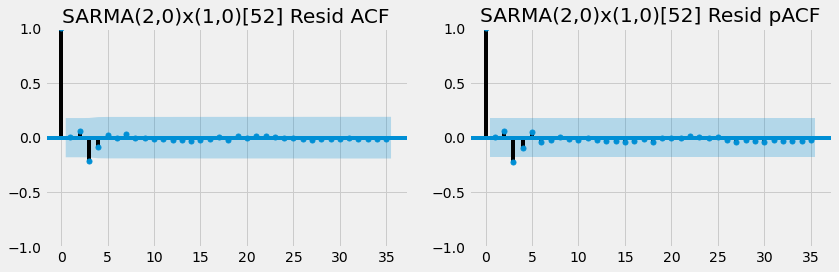

In [55]:

df_model_residuals  = pd.DataFrame(model.resid)
display(df_model_residuals.describe())

#df_model_residuals.plot()
#df_model_residuals.plot(kind='kde')
#plt.title(f'ARIMA{pdqParmas_list[inc]} Residuals')
#plt.show()

# Plot Resiudals
ts_fig_size = (10, 4)
acf_pacf_fig_size = (12,4)

#Plot Time Series
plt.figure(figsize= ts_fig_size, dpi=80)
plt.plot( df_model_residuals, marker='o')
plt.title(f'{model_name} Residual Time Series')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Weeks)')
plt.ylabel('Residual')
plt.show()


# acf pacf plts
fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
# acf
sm.graphics.tsa.plot_acf(df_model_residuals.values.squeeze(), lags=35, ax=ax[0], title=f'{model_name} Resid ACF')
# pacf
sm.graphics.tsa.plot_pacf(df_model_residuals, lags=35, ax=ax[1], title=f'{model_name} Resid pACF') 
plt.tight_layout()
plt.show()




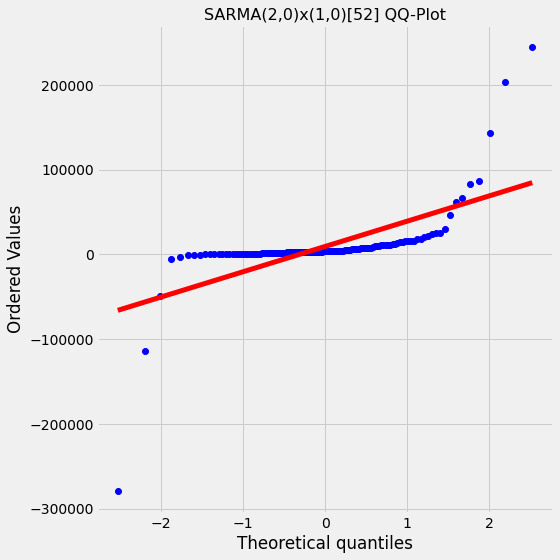



SARMA(2,0)x(1,0)[52]
Shapiro-Wilk Test:
ShapiroResult(statistic=0.5359777808189392, pvalue=1.202452074738043e-16)
p-value: 0.0. The null-hypothesis can be rejected. The data is not normally distributed.


ShapiroResult(statistic=0.5359777808189392, pvalue=1.202452074738043e-16)

In [56]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1,1, 1)
res = stats.probplot(model.resid, plot=plt)


#ax.get_lines()[0].set_marker('o')
#ax.get_lines()[0].set_markerfacecolor(line_color_list[inc])
#ax.get_lines()[0].set_markersize(4)

ax.get_lines()[1].set_linewidth(5)
plt.title(f'{model_name} QQ-Plot', fontsize=16)
plt.tight_layout()
plt.show()


print(f'\n\n{model_name}')
shapiro_wilk_test(model.resid)




SARMA(2,0)x(1,0)[52]


,lb_stat,lb_pvalue
30,8.138057,0.999976


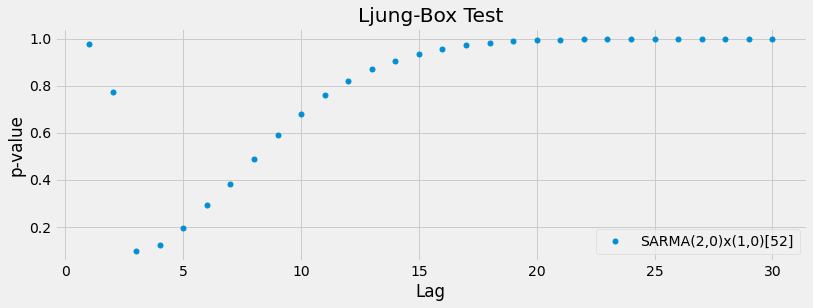

In [58]:
#Ljung Box Test

fig = plt.figure(figsize = (12, 4))
print('\n\n')
print(f'{model_name}')
lbt_array = sm.stats.acorr_ljungbox(pd.DataFrame(model.resid), lags=30)
display(lbt_array.tail(1))

#plt.plot(lbt_array.lb_pvalue, marker='o', markersize=5, linewidth=0)
plt.plot(lbt_array.lb_pvalue, marker='o', markersize=5, linewidth=0, label= f'{model_name}')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title(f'Ljung-Box Test')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


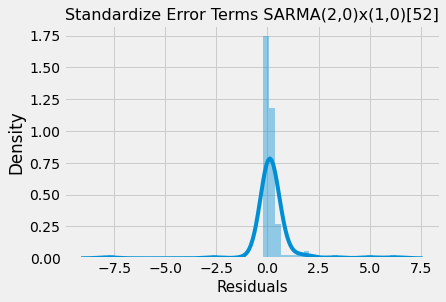

In [59]:
# Standardize Residuals
#fig = plt.figure(figsize = (12, 4))
sqr_dev_mean = ((model.resid - model.resid.mean())**2).sum()
ar_resid_leverage = 1/model.resid.count()+(model.resid- model.resid.mean())**2 / sqr_dev_mean

ar_std_residuals = model.resid/ (model.resid.std() * (1-ar_resid_leverage)**(1/2))

#ax = fig.add_subplot(1,2, inc+1)
sns.distplot(ar_std_residuals) # you may select the no. of bins
plt.title(f'Standardize Error Terms {model_name}', fontsize=16)           
plt.xlabel('Residuals', fontsize = 15) 
#plt.tight_layout()    
plt.show()

In [60]:
display(df_accuracy_metrics) 

,model,k,mape,mae,mpe,rmse,corr,minmax,aic,bic,llf
0,"SARMA(2,0)x(1,0)[52]",0,0.284,13318.260,-0.088,17609.300,NaN,0.265,373.81,376.79,-183.90
1,"SARIMA(3,0,0)x(0,1,0)[52]",0,0.560,18680.665,0.305,20129.267,NaN,0.365,367.54,371.53,-179.77
2,"SARMA(2,0)x(1,0)[52]",1,0.787,137030.376,-0.787,168736.359,NaN,0.787,725.97,730.81,-359.99
3,"SARIMA(3,0,0)x(0,1,0)[52]",1,0.787,136938.365,-0.787,168634.155,NaN,0.787,728.03,734.47,-360.02
4,"SARMA(2,0)x(1,0)[52]",2,0.870,10418.019,-0.862,11445.527,NaN,0.870,1221.57,1227.54,-607.78
5,"SARIMA(3,0,0)x(0,1,0)[52]",2,1.092,13261.854,-1.086,14480.494,NaN,1.091,1223.57,1231.53,-607.79
6,"SARMA(2,0)x(1,0)[52]",3,0.795,47075.006,-0.789,56225.213,NaN,0.795,1583.80,1590.59,-788.90
7,"SARIMA(3,0,0)x(0,1,0)[52]",3,0.798,47181.622,-0.792,56333.236,NaN,0.798,1585.79,1594.84,-788.90
8,"SARMA(2,0)x(1,0)[52]",4,0.698,197015.501,-0.698,331721.916,NaN,0.698,1945.32,1952.75,-969.66
9,"SARIMA(3,0,0)x(0,1,0)[52]",4,0.714,197959.114,-0.714,332331.859,NaN,0.714,1947.28,1957.19,-969.64


# Forecasting The Next Year

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


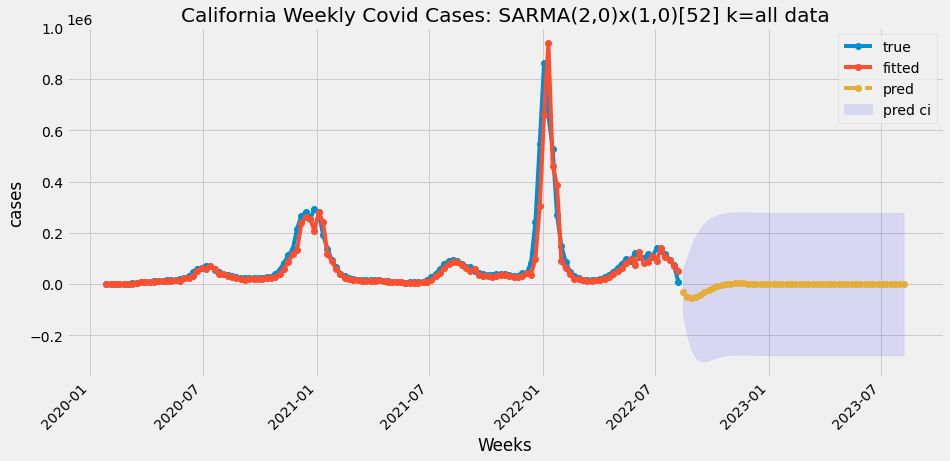

In [62]:
data_all = pd.concat([data_train, data_val, data_test], axis = 0)

df_acc_train_val = pd.DataFrame()
y_true = data_test.values

# fit model
model = SARIMAX(data_all, order=pdqParams, season_order= PDQParams).fit()

# forecast
data_pred = model.forecast(52)
fcast = model.get_forecast(52)
ci = fcast.conf_int()
y_pred = data_pred.values

# measure accuracy


# Plot
plt.figure(figsize=(14, 6))

# Loop
# AR Plot
#plt.subplot(len(model_list),1, (inc+1))
plt.plot(pd.concat([data_train_all, data_test], axis=0), marker='o', label= 'true')
plt.plot(model.fittedvalues, marker='o', label= 'fitted')
plt.plot(data_pred, line_pred_style, marker='o', label= 'pred')
plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color='blue', alpha=0.1, label = f'pred ci')
plt.title(f'California Weekly Covid Cases: {model_name} k=all data')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Weeks')
plt.ylabel('cases')

plt.legend()
plt.show()